# Importing Libraries

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os, datetime
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler,LabelEncoder,StandardScaler
from sklearn.decomposition import PCA, non_negative_factorization
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
from sklearn.cluster import KMeans, AgglomerativeClustering,MeanShift,DBSCAN,Birch
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, f1_score, roc_auc_score,recall_score

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"



## About Dataset
This dataset is taken from **KAGGLE**. 
## Context
## Problem Statement

Customer Personality Analysis is a detailed analysis of a company’s ideal customers. It helps a business to better understand its customers and makes it easier for them to modify products according to the specific needs, behaviors and concerns of different types of customers.

Customer personality analysis helps a business to modify its product based on its target customers from different types of customer segments. For example, instead of spending money to market a new product to every customer in the company’s database, a company can analyze which customer segment is most likely to buy the product and then market the product only on that particular segment.

#### Link of the dataset 
https://www.kaggle.com/datasets/imakash3011/customer-personality-analysis?select=marketing_campaign.csv

### Content
### Attributes

#### People

* ID: Customer's unique identifier
* Year_Birth: Customer's birth year
* Education: Customer's education level
* Marital_Status: Customer's marital status
* Income: Customer's yearly household income
* Kidhome: Number of children in customer's household
* Teenhome: Number of teenagers in customer's household
* Dt_Customer: Date of customer's enrollment with the company
* Recency: Number of days since customer's last purchase
* Complain: 1 if the customer complained in the last 2 years, 0 otherwise

#### Products

* MntWines: Amount spent on wine in last 2 years
* MntFruits: Amount spent on fruits in last 2 years
* MntMeatProducts: Amount spent on meat in last 2 years
* MntFishProducts: Amount spent on fish in last 2 years
* MntSweetProducts: Amount spent on sweets in last 2 years
* MntGoldProds: Amount spent on gold in last 2 years

#### Promotion

* NumDealsPurchases: Number of purchases made with a discount
* AcceptedCmp1: 1 if customer accepted the offer in the 1st campaign, 0 otherwise
* AcceptedCmp2: 1 if customer accepted the offer in the 2nd campaign, 0 otherwise
* AcceptedCmp3: 1 if customer accepted the offer in the 3rd campaign, 0 otherwise
* AcceptedCmp4: 1 if customer accepted the offer in the 4th campaign, 0 otherwise
* AcceptedCmp5: 1 if customer accepted the offer in the 5th campaign, 0 otherwise
* Response: 1 if customer accepted the offer in the last campaign, 0 otherwise

#### Place

* NumWebPurchases: Number of purchases made through the company’s website
* NumCatalogPurchases: Number of purchases made using a catalogue
* NumStorePurchases: Number of purchases made directly in stores
* NumWebVisitsMonth: Number of visits to company’s website in the last month

#### Purpose of this exercise
* Need to perform clustering to summarize customer segments.



# Main objective
In this project, We will be performing unsupervised clustering on the customer's data from a groceries firm's database. Customer segmentation is the practice of separating customers into groups that reflect similarities among customers in each cluster. We will divide the customers into segments to understand the behaviour of customers as a group to the business. To modify products according to distinct needs of the customers. 

# Stakeholders
By this analysis, our stakeholders will get to know customer behaviour, who are our most loyal customers and customer who are visting the store less.
It also helps the business to cater to the concerns of different types of customers.

In [2]:
data=pd.read_csv('/kaggle/input/customer-personality-analysis/marketing_campaign.csv', sep="\t")

In [3]:
pd.set_option('display.max_columns', None)

# Data Cleaning and Exploration

In [4]:
data.shape

(2240, 29)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

In [6]:
# Categorical Variables encoded
labels = LabelEncoder()
data.Marital_Status=labels.fit_transform(data.Marital_Status)
data.Education=labels.fit_transform(data.Education)

In [7]:
# year_birth converted to age
data["age"]=datetime.datetime.today().year-data.Year_Birth
data=data.drop("Year_Birth",axis=1)

In [8]:
# renaming column names for more meaning
data.columns=['ID', 'education', 'marital_status', 'income', 'kidhome',
       'teenhome', 'cust_enrol_dt', 'recency', 'amt_spent_wine_last_2_yr', 'amt_spent_fruits_last_2_yr',
       'amt_spent_meat_last_2_yr', 'amt_spent_fish_last_2_yr', 'amt_spent_sweet_last_2_yr',
       'amt_spent_gold_last_2_yr', 'num_deals_purchases', 'num_web_purchases',
       'num_catalog_purchases','num_store_purchases','num_web_visits_month',
       'accepted_cmp3', 'accepted_cmp4', 'accepted_cmp5', 'accepted_cmp1',
       'accepted_cmp2', 'complain', 'Z_cost_contact', 'Z_revenue', 'response',
       'age']
cols=data.columns
# dt_customer column data type corrected
data.cust_enrol_dt=pd.to_datetime(data.cust_enrol_dt)
data.head()

/tmp/ipykernel_20/153973896.py:12: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  data.cust_enrol_dt=pd.to_datetime(data.cust_enrol_dt)


,ID,education,marital_status,income,kidhome,teenhome,cust_enrol_dt,recency,amt_spent_wine_last_2_yr,amt_spent_fruits_last_2_yr,amt_spent_meat_last_2_yr,amt_spent_fish_last_2_yr,amt_spent_sweet_last_2_yr,amt_spent_gold_last_2_yr,num_deals_purchases,num_web_purchases,num_catalog_purchases,num_store_purchases,num_web_visits_month,accepted_cmp3,accepted_cmp4,accepted_cmp5,accepted_cmp1,accepted_cmp2,complain,Z_cost_contact,Z_revenue,response,age
0,5524,2,4,58138.0,0,0,2012-04-09,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,3,11,1,66
1,2174,2,4,46344.0,1,1,2014-08-03,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,3,11,0,69
2,4141,2,5,71613.0,0,0,2013-08-21,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,3,11,0,58
3,6182,2,5,26646.0,1,0,2014-10-02,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,3,11,0,39
4,5324,4,3,58293.0,1,0,2014-01-19,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,3,11,0,42


In [9]:
# Now we can use this dataset for clustering as none of the columns are categorical
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   ID                          2240 non-null   int64         
 1   education                   2240 non-null   int64         
 2   marital_status              2240 non-null   int64         
 3   income                      2216 non-null   float64       
 4   kidhome                     2240 non-null   int64         
 5   teenhome                    2240 non-null   int64         
 6   cust_enrol_dt               2240 non-null   datetime64[ns]
 7   recency                     2240 non-null   int64         
 8   amt_spent_wine_last_2_yr    2240 non-null   int64         
 9   amt_spent_fruits_last_2_yr  2240 non-null   int64         
 10  amt_spent_meat_last_2_yr    2240 non-null   int64         
 11  amt_spent_fish_last_2_yr    2240 non-null   int64       

In [10]:
# Finding the unique values in every column
pd.DataFrame([[i, len(data[i].unique())] for i in data.columns],
             columns=['Variable', 'Unique Values']).set_index('Variable')

,Unique Values
Variable,
ID,2240
education,5
marital_status,8
income,1975
kidhome,3
teenhome,3
cust_enrol_dt,663
recency,100
amt_spent_wine_last_2_yr,776


In [11]:
# Check for missing values in dataset  - Missing values are handled using imputation
# All the variables are numeric in nature
data.income=data.income.fillna(np.mean(data.income))
data.isna().sum()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   ID                          2240 non-null   int64         
 1   education                   2240 non-null   int64         
 2   marital_status              2240 non-null   int64         
 3   income                      2240 non-null   float64       
 4   kidhome                     2240 non-null   int64         
 5   teenhome                    2240 non-null   int64         
 6   cust_enrol_dt               2240 non-null   datetime64[ns]
 7   recency                     2240 non-null   int64         
 8   amt_spent_wine_last_2_yr    2240 non-null   int64         
 9   amt_spent_fruits_last_2_yr  2240 non-null   int64         
 10  amt_spent_meat_last_2_yr    2240 non-null   int64         
 11  amt_spent_fish_last_2_yr    2240 non-null   int64       

In [12]:
# Check for duplicate customer ids # no duplicate ids found
assert data.ID.duplicated(keep=False).count()==data.shape[0]

Text(0.5, 1.0, 'Boxplot')

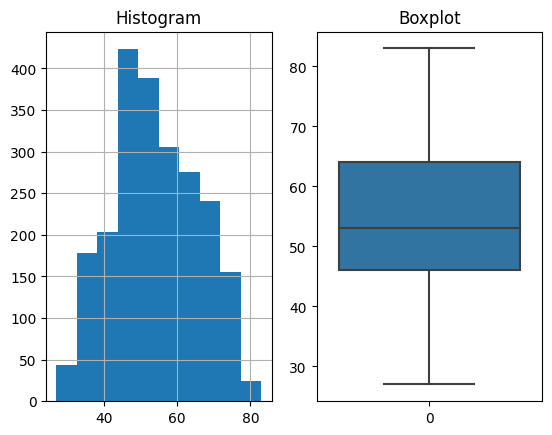

In [13]:
# From the Histogram it is clear that there are some people whose age is greated than 120 on an average people live around 100 years
# So removing age values which are greater than 100
data=data[data.age<=100]
f, (ax1, ax2) = plt.subplots(1, 2)
data.age.hist(ax=ax1)
ax1.set_title("Histogram")
sns.boxplot(data.age,ax=ax2)
ax2.set_title("Boxplot")

/tmp/ipykernel_20/2608723067.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data.corr(), annot = True, linewidths=0,fmt='.2f',annot_kws={"size": 8})


<AxesSubplot: >

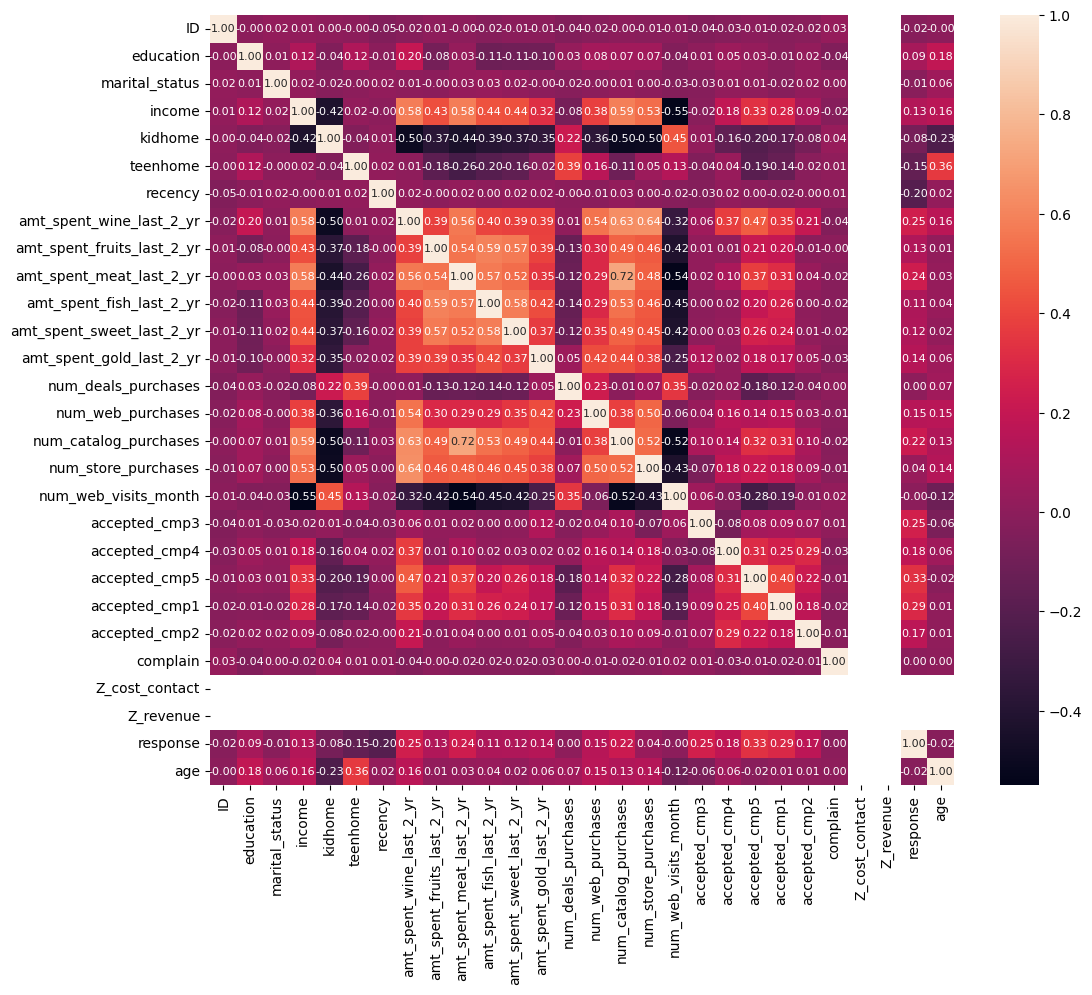

In [14]:
# Checking the correlation between varibles
plt.figure(figsize = (12, 10))
sns.heatmap(data.corr(), annot = True, linewidths=0,fmt='.2f',annot_kws={"size": 8})

# Standardize the data

In [15]:
# Features to be considered
X=data.drop(['cust_enrol_dt','ID'],axis=1)
mms=MinMaxScaler()
transformed_data=mms.fit_transform(X)
scaled_data=pd.DataFrame(transformed_data)
scaled_data.columns=set(cols)-{'cust_enrol_dt','ID'}
scaled_data.head()

,response,amt_spent_fruits_last_2_yr,teenhome,accepted_cmp4,amt_spent_fish_last_2_yr,Z_cost_contact,accepted_cmp1,amt_spent_wine_last_2_yr,age,amt_spent_meat_last_2_yr,num_web_visits_month,num_deals_purchases,kidhome,Z_revenue,accepted_cmp5,recency,marital_status,num_store_purchases,accepted_cmp2,num_web_purchases,num_catalog_purchases,income,complain,amt_spent_gold_last_2_yr,amt_spent_sweet_last_2_yr,accepted_cmp3,education
0,0.5,0.571429,0.084832,0.0,0.0,0.585859,0.425318,0.442211,0.316522,0.664093,0.334601,0.243094,0.200000,0.296296,0.357143,0.307692,0.35,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.696429
1,0.5,0.571429,0.067095,0.5,0.5,0.383838,0.007368,0.005025,0.003478,0.007722,0.003802,0.016575,0.133333,0.037037,0.035714,0.153846,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.750000
2,0.5,0.714286,0.105097,0.0,0.0,0.262626,0.285332,0.246231,0.073623,0.428571,0.079848,0.116022,0.066667,0.296296,0.071429,0.769231,0.20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.553571
3,0.5,0.714286,0.037471,0.5,0.0,0.262626,0.007368,0.020101,0.011594,0.038610,0.011407,0.013812,0.133333,0.074074,0.000000,0.307692,0.30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.214286
4,1.0,0.428571,0.085065,0.5,0.0,0.949495,0.115874,0.216080,0.068406,0.177606,0.102662,0.041436,0.333333,0.185185,0.107143,0.461538,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.267857


# Model Training and Predictions

# Kmeans

In [16]:
# From the plot it is okay to create 4-5 clusters
kmeans=KMeans(n_clusters=4)
kmeans.fit(transformed_data)

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=4)

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:8

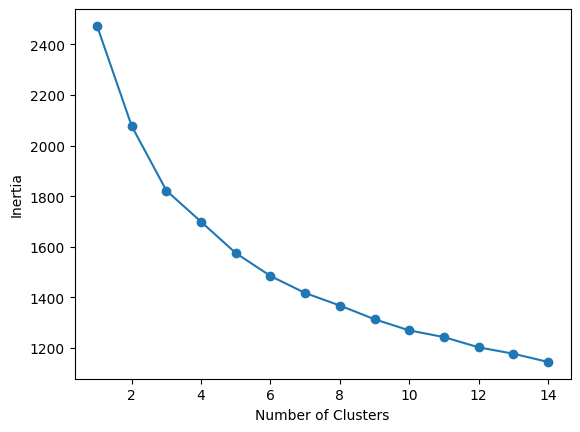

In [17]:
# Plot to find optimal K

inertia = []
list_num_clusters = list(range(1,15))
for num_clusters in list_num_clusters:
    km = KMeans(n_clusters=num_clusters)
    km.fit(transformed_data)
    inertia.append(km.inertia_)
    
plt.plot(list_num_clusters,inertia)
plt.scatter(list_num_clusters,inertia)
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia');
### END SOLUTION

In [18]:
kmeans_labels=kmeans.labels_
set(kmeans.labels_)

{0, 1, 2, 3}

# Agglomerative clustering

In [19]:
agc=AgglomerativeClustering(n_clusters=4)
agc.fit(transformed_data)

AgglomerativeClustering(n_clusters=4)

In [20]:
agc_labels=agc.labels_
set(agc.labels_)

{0, 1, 2, 3}

# BIRCH

In [21]:
birch=Birch(n_clusters=4)
birch.fit(transformed_data)

Birch(n_clusters=4)

In [22]:
# 4 clusters generated
birch_labels=birch.labels_
set(birch.labels_)

{0, 1, 2, 3}

# Aggregate all the clusters labels into original dataframe with the help of mode and analyze clusters

In [23]:
data['kmeans']=kmeans_labels
data['agc']=agc_labels
data['birch']=birch_labels

In [24]:
df_clusters=data[["kmeans","agc","birch"]]
data['voting_labels']=df_clusters.mode(axis=1)[0]

# Analyze Clusters

In [25]:
df_c1=data[data.voting_labels==1]
df_c1.describe()

,ID,education,marital_status,income,kidhome,teenhome,recency,amt_spent_wine_last_2_yr,amt_spent_fruits_last_2_yr,amt_spent_meat_last_2_yr,amt_spent_fish_last_2_yr,amt_spent_sweet_last_2_yr,amt_spent_gold_last_2_yr,num_deals_purchases,num_web_purchases,num_catalog_purchases,num_store_purchases,num_web_visits_month,accepted_cmp3,accepted_cmp4,accepted_cmp5,accepted_cmp1,accepted_cmp2,complain,Z_cost_contact,Z_revenue,response,age,kmeans,agc,birch,voting_labels
count,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.00000,96.000000,96.00000,96.000000,96.000000,96.000000,96.0,96.0,96.000000,96.000000,96.000000,96.0,96.0,96.000000,96.000000,96.0,96.0,96.0,96.0
mean,5537.083333,2.447917,3.656250,81698.648452,0.031250,0.083333,48.760417,823.989583,64.791667,503.677083,85.427083,73.083333,87.218750,1.00000,5.479167,6.28125,8.354167,2.562500,0.250000,0.0,1.0,0.312500,0.052083,0.010417,3.0,11.0,0.541667,52.614583,1.0,3.0,1.0,1.0
std,2971.937775,1.094193,1.093792,8485.413597,0.174906,0.313442,29.441019,296.787484,50.732719,261.692648,62.563104,53.032992,66.050252,0.66491,1.989336,2.44391,2.745251,1.520474,0.435286,0.0,0.0,0.465946,0.223361,0.102062,0.0,0.0,0.500876,14.281655,0.0,0.0,0.0,0.0
min,175.000000,0.000000,0.000000,52247.251354,0.000000,0.000000,1.000000,162.000000,0.000000,61.000000,0.000000,0.000000,0.000000,0.00000,2.000000,2.00000,4.000000,1.000000,0.000000,0.0,1.0,0.000000,0.000000,0.000000,3.0,11.0,0.000000,28.000000,1.0,3.0,1.0,1.0
25%,3550.000000,2.000000,3.000000,77452.000000,0.000000,0.000000,23.000000,608.250000,22.000000,289.250000,38.000000,28.750000,33.000000,1.00000,4.000000,4.00000,6.000000,1.000000,0.000000,0.0,1.0,0.000000,0.000000,0.000000,3.0,11.0,0.000000,40.750000,1.0,3.0,1.0,1.0
50%,5548.000000,2.000000,3.000000,82358.500000,0.000000,0.000000,54.000000,826.500000,49.500000,500.500000,64.000000,60.500000,71.500000,1.00000,5.000000,6.00000,8.000000,2.000000,0.000000,0.0,1.0,0.000000,0.000000,0.000000,3.0,11.0,1.000000,50.500000,1.0,3.0,1.0,1.0
75%,7799.750000,3.000000,5.000000,86919.750000,0.000000,0.000000,75.250000,1006.000000,100.000000,731.500000,125.250000,114.000000,119.750000,1.00000,7.000000,8.00000,10.250000,3.000000,0.250000,0.0,1.0,1.000000,0.000000,0.000000,3.0,11.0,1.000000,64.000000,1.0,3.0,1.0,1.0
max,11101.000000,4.000000,6.000000,105471.000000,1.000000,2.000000,98.000000,1486.000000,185.000000,968.000000,250.000000,192.000000,245.000000,5.00000,11.000000,11.00000,13.000000,7.000000,1.000000,0.0,1.0,1.000000,1.000000,1.000000,3.0,11.0,1.000000,82.000000,1.0,3.0,1.0,1.0


In [26]:
df_c2=data[data.voting_labels==2]
df_c2.describe()

,ID,education,marital_status,income,kidhome,teenhome,recency,amt_spent_wine_last_2_yr,amt_spent_fruits_last_2_yr,amt_spent_meat_last_2_yr,amt_spent_fish_last_2_yr,amt_spent_sweet_last_2_yr,amt_spent_gold_last_2_yr,num_deals_purchases,num_web_purchases,num_catalog_purchases,num_store_purchases,num_web_visits_month,accepted_cmp3,accepted_cmp4,accepted_cmp5,accepted_cmp1,accepted_cmp2,complain,Z_cost_contact,Z_revenue,response,age,kmeans,agc,birch,voting_labels
count,902.000000,902.000000,902.000000,902.000000,902.000000,902.000000,902.000000,902.000000,902.000000,902.000000,902.000000,902.000000,902.000000,902.000000,902.000000,902.000000,902.000000,902.000000,902.0,902.0,902.0,902.0,902.0,902.000000,902.0,902.0,902.0,902.000000,902.000000,902.0,902.0,902.0
mean,5644.920177,2.252772,3.687361,38275.990319,0.891353,0.410200,51.699557,80.864745,8.566519,42.390244,11.790466,8.342572,19.853659,2.478936,2.623060,0.762749,3.820399,6.409091,0.0,0.0,0.0,0.0,0.0,0.018847,3.0,11.0,0.0,50.904656,2.777162,2.0,2.0,2.0
std,3261.773822,1.127975,1.023495,26852.066385,0.441157,0.529094,28.026656,150.770995,16.818398,71.090840,20.049644,15.778543,27.163146,2.031139,2.031888,1.201751,2.033271,1.955681,0.0,0.0,0.0,0.0,0.0,0.136060,0.0,0.0,0.0,10.765269,0.787111,0.0,0.0,0.0
min,9.000000,0.000000,1.000000,1730.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,3.0,11.0,0.0,28.000000,0.000000,2.0,2.0,2.0
25%,2875.500000,2.000000,3.000000,26672.250000,1.000000,0.000000,29.000000,8.000000,1.000000,8.000000,2.000000,1.000000,4.000000,1.000000,1.000000,0.000000,3.000000,5.000000,0.0,0.0,0.0,0.0,0.0,0.000000,3.0,11.0,0.0,43.000000,3.000000,2.0,2.0,2.0
50%,5637.500000,2.000000,3.000000,35791.000000,1.000000,0.000000,51.000000,23.000000,3.000000,16.500000,4.000000,3.000000,10.000000,2.000000,2.000000,0.000000,3.000000,7.000000,0.0,0.0,0.0,0.0,0.0,0.000000,3.0,11.0,0.0,50.000000,3.000000,2.0,2.0,2.0
75%,8413.250000,3.000000,5.000000,46335.500000,1.000000,1.000000,77.000000,76.750000,8.000000,45.000000,13.000000,9.000000,24.000000,3.000000,3.000000,1.000000,4.000000,8.000000,0.0,0.0,0.0,0.0,0.0,0.000000,3.0,11.0,0.0,58.000000,3.000000,2.0,2.0,2.0
max,11191.000000,4.000000,6.000000,666666.000000,2.000000,2.000000,99.000000,1181.000000,159.000000,650.000000,179.000000,147.000000,262.000000,15.000000,11.000000,10.000000,13.000000,20.000000,0.0,0.0,0.0,0.0,0.0,1.000000,3.0,11.0,0.0,83.000000,3.000000,2.0,2.0,2.0


In [27]:
df_c3=data[data.voting_labels==3]
df_c3

,ID,education,marital_status,income,kidhome,teenhome,cust_enrol_dt,recency,amt_spent_wine_last_2_yr,amt_spent_fruits_last_2_yr,amt_spent_meat_last_2_yr,amt_spent_fish_last_2_yr,amt_spent_sweet_last_2_yr,amt_spent_gold_last_2_yr,num_deals_purchases,num_web_purchases,num_catalog_purchases,num_store_purchases,num_web_visits_month,accepted_cmp3,accepted_cmp4,accepted_cmp5,accepted_cmp1,accepted_cmp2,complain,Z_cost_contact,Z_revenue,response,age,kmeans,agc,birch,voting_labels
32,5710,2,5,40548.000000,0,1,2012-10-10,31,110,0,5,2,0,3,2,2,1,4,5,0,1,0,0,0,0,3,11,0,53,3,0,3,3.0
60,6853,3,4,75777.000000,0,0,2013-04-07,12,712,26,538,69,13,80,1,3,6,11,1,0,1,1,0,0,0,3,11,1,41,1,3,3,3.0
86,273,3,3,36138.000000,1,1,2013-07-16,48,130,0,16,0,0,5,5,3,1,4,7,0,1,0,0,0,0,3,11,0,53,3,0,3,3.0
113,999,2,4,86037.000000,0,0,2013-02-01,95,490,44,125,29,20,22,1,6,7,11,3,0,1,1,0,0,0,3,11,1,32,1,3,3,3.0
116,1592,2,3,90765.000000,0,0,2014-01-24,25,547,99,812,151,82,33,0,4,6,5,1,0,0,1,1,0,0,3,11,0,53,1,3,3,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2125,2088,2,5,84906.000000,0,0,2013-04-10,98,997,15,414,99,30,76,1,5,6,12,2,0,1,1,0,1,0,3,11,0,51,1,3,3,3.0
2144,5136,2,4,65333.000000,0,1,2014-01-17,58,654,7,92,0,15,30,7,9,4,8,6,0,1,1,0,0,0,3,11,0,50,1,3,3,3.0
2207,4333,2,5,32144.000000,1,1,2014-03-23,76,41,0,10,0,0,3,4,2,1,3,7,0,1,0,0,0,0,3,11,0,69,3,0,3,3.0
2221,7366,3,4,75777.000000,0,0,2013-04-07,12,712,26,538,69,13,80,1,3,6,11,1,0,1,1,0,0,0,3,11,1,41,1,3,3,3.0


In [28]:
df_c4=data[data.voting_labels==0]
df_c4.describe()

,ID,education,marital_status,income,kidhome,teenhome,recency,amt_spent_wine_last_2_yr,amt_spent_fruits_last_2_yr,amt_spent_meat_last_2_yr,amt_spent_fish_last_2_yr,amt_spent_sweet_last_2_yr,amt_spent_gold_last_2_yr,num_deals_purchases,num_web_purchases,num_catalog_purchases,num_store_purchases,num_web_visits_month,accepted_cmp3,accepted_cmp4,accepted_cmp5,accepted_cmp1,accepted_cmp2,complain,Z_cost_contact,Z_revenue,response,age,kmeans,agc,birch,voting_labels
count,1162.000000,1162.000000,1162.000000,1162.000000,1162.000000,1162.000000,1162.000000,1162.000000,1162.000000,1162.000000,1162.000000,1162.000000,1162.000000,1162.000000,1162.000000,1162.000000,1162.000000,1162.000000,1162.000000,1162.000000,1162.000000,1162.000000,1162.000000,1162.000000,1162.0,1162.0,1162.000000,1162.000000,1162.000000,1162.000000,1162.000000,1162.0
mean,5567.524957,2.487952,3.749570,58943.201603,0.150602,0.628227,46.978485,399.988812,36.050775,221.831325,52.448365,36.522375,58.503442,2.375215,5.043890,3.687608,7.000000,4.803787,0.119621,0.083477,0.000861,0.065404,0.012048,0.001721,3.0,11.0,0.209122,56.624785,0.881239,0.246127,1.524957,0.0
std,3250.139360,1.118450,1.109867,17738.971731,0.367317,0.537479,29.547644,303.467791,44.776851,235.001437,62.911785,46.115702,57.377473,1.898003,2.866955,3.016407,3.268886,2.423554,0.324658,0.276721,0.029336,0.247345,0.109148,0.041469,0.0,0.0,0.406857,11.468055,1.202786,0.448567,0.946354,0.0
min,0.000000,0.000000,0.000000,2447.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000,27.000000,0.000000,0.000000,0.000000,0.0
25%,2784.750000,2.000000,3.000000,47713.000000,0.000000,0.000000,21.000000,157.250000,3.000000,49.000000,4.000000,3.000000,17.000000,1.000000,3.000000,1.000000,4.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000,48.000000,0.000000,0.000000,1.000000,0.0
50%,5373.500000,2.000000,4.000000,61285.000000,0.000000,1.000000,47.000000,362.000000,17.000000,134.500000,25.000000,16.000000,38.000000,2.000000,5.000000,3.000000,7.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000,57.000000,0.000000,0.000000,2.000000,0.0
75%,8536.250000,3.000000,5.000000,71111.500000,0.000000,1.000000,72.000000,587.000000,53.000000,332.750000,80.000000,53.000000,83.000000,3.000000,7.000000,5.000000,10.000000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000,66.000000,2.000000,0.000000,2.000000,0.0
max,11176.000000,4.000000,7.000000,160803.000000,2.000000,2.000000,99.000000,1396.000000,199.000000,1725.000000,259.000000,263.000000,362.000000,15.000000,27.000000,28.000000,13.000000,20.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.0,11.0,1.000000,80.000000,3.000000,3.000000,3.000000,0.0


# Summary and key insights

I have created 5 models logistic, KNN, decision tree, random forests and gradient boosting and used five different validation metrices. below is the summary of all provided how they have performed.
All the models are trained on same training sets and tested on same test sets. Also, almost all of the models used same parameters.
From the **confusion matrix** it is evident that **Logistic Regression** performed very badly with **0 precision and recall**.
KNN and Decision Tree model gave some edge as precision, recall and f1 scores starts to improve in these two models by decreasing some accuracy
I think gradient boosting method have performed very well as compared to other models with highest accuracy,Precision, recall and highest f1-score.



# Feature Importance

# Suggestions and next steps for revisiting the model

We could further optimize these models
1. Using **GridSearchCV** that will find the best parameters for every model.
2. Using Sampling because data is **unbalanced**, so we can also look from that angle also to increase the accuracy of the model.
3. We could also change our model based on the **inputs received from our stakeholders** about the business.
4. We could also use XGboost model